# Fully-saturated TWFE

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
from patsy import dmatrix
import pymc as pm
import arviz as az
az.style.use('arviz-darkgrid')

rng = np.random.default_rng(42)
figsize = (10, 5)

In [2]:
filepath = '../../data/processed/df_filtered.xlsx'
df = pd.read_excel(filepath)
df = df.dropna(subset=['population'])
df.loc[df['treatment_group'] == 0, 'time_since_treatment'] = np.nan # コントロール群の処置後経過年数は欠損値
df['time_since_treatment'] = np.nan_to_num(df['time_since_treatment'], nan=1000)

df.island_ids = df.island_ids.astype(str)
df.island_ids = df.island_ids.map(str.strip)
island_id, mn_island_ids = df.island_ids.factorize()

df.bridge_year = df.bridge_year.astype(str)
df.bridge_year = df.bridge_year.map(str.strip)
bridge_year, mn_bridge_years = df.bridge_year.factorize()

$$
\begin{aligned}
\log{Y^{**}_{it}} &\sim \mathcal{t} (\nu, \mu_{it}, \sigma_i^2) \\
\nu &\sim \text{Exponential}(1/10) \\
\mu_{it} &= \alpha + \beta_{gl} \cdot T_{i} \\
\alpha &\sim \mathcal{N}(0, 0.1^2) \\
\beta_{gl} &\sim \mathcal{N}(\mu_{\beta}, \sigma_{\beta}^2) \\
\sigma_i &\sim \mathcal{C}^+(\sigma_0^2) \\
\end{aligned}
$$

- $\beta_{gl}$: 介入時期 $g$ と介入経過時間 $l$ によって変動する介入効果
- $T_{it}$: 介入群ダミー
- $\mu_{\beta} \sim N(0, 0.3^2)$: 介入時期と介入経過時間の期待値を表すハイパーパラメータ
- $\sigma_{\beta}^2 \sim N^+(0.3^2)$: 介入時期と介入経過時間の分散を表すハイパーパラメータ
- $\sigma_0^2 \sim N^+(0.24^2)$: 島間の誤差分散を表すハイパーパラメータ
- $\sigma_i^2$: 島間の誤差分散

## サンプリングのインポート

In [3]:
trace_homo = az.from_netcdf('./mcmc_sample/fully_saturated/homo_kokucho_20250109.nc')

## 階層ベイズモデル 不均一分散

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/pymc/model/core.py:1302: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


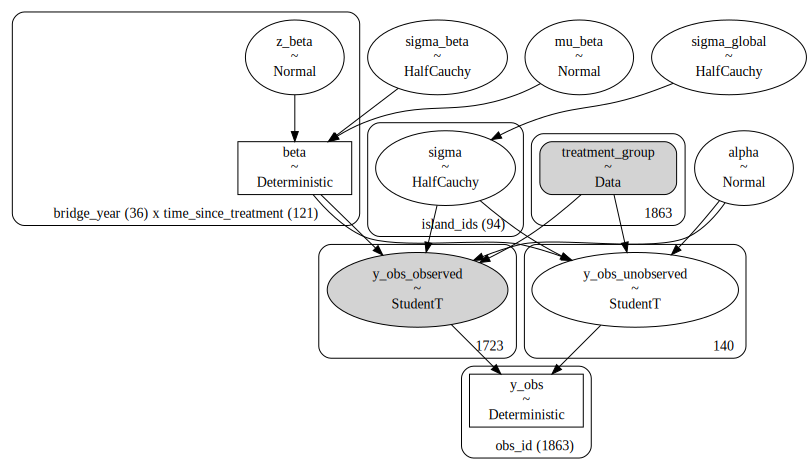

In [4]:
COORDS = {
    'obs_id': df.index,
    'island_ids': mn_island_ids,
    'bridge_year': mn_bridge_years,
    'time_since_treatment': mn_time_since_treatments,
}

with pm.Model(coords=COORDS) as model_h_hetero:
    # data
    # island_ids = pm.Data('island_ids', island_ids)
    # bridge_year = pm.Data('bridge_year', bridge_year)
    treatment_group = pm.Data('treatment_group', df['treatment_group'])
    # time_since_treatment = pm.Data('time_since_treatment', time_since_treatment)

    # priors
    # ATT
    mu_beta = pm.Normal('mu_beta', mu=0, sigma=0.1)
    sigma_beta = pm.HalfCauchy('sigma_beta', 0.1)
    z_beta = pm.Normal('z_beta', mu=0, sigma=1, dims=('bridge_year', 'time_since_treatment'))
    beta = pm.Deterministic('beta', mu_beta + sigma_beta * z_beta, dims=('bridge_year', 'time_since_treatment'))

    # sigma
    sigma_global = pm.HalfCauchy('sigma_global', 0.15)
    sigma = pm.HalfCauchy('sigma', sigma_global, dims='island_ids')

    # fixed effects
    alpha = pm.Normal('alpha', mu=0, sigma=0.1)
    nu = 7

    # expected value
    mu = alpha + beta[bridge_year, time_since_treatment] * treatment_group

    # likelihood
    y_obs = pm.StudentT('y_obs', mu=mu, sigma=sigma[island_id], nu=nu, observed=df['log_pop_star'], dims='obs_id')

pm.model_to_graphviz(model_h_hetero)

In [5]:
with model_h_hetero:
    trace_h_hetero = pm.sample(
        draws=2500,
        tune=1000,
        chains=4,
        cores=4,
        nuts_sampler='numpyro',
        random_seed=rng,
        target_accept=0.95, # これを設定しないとチェーンが動かない
    )

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [1]:
trace_h_hetero = az.from_netcdf('./mcmc_sample/fully_saturated/hie_hetero_const_20250108.nc')

NameError: name 'az' is not defined

In [1]:
# サンプリングの保存
az.to_netcdf(trace_h_hetero, './mcmc_sample/fully_saturated/hie_hetero_const_20250108.nc')

NameError: name 'az' is not defined

In [7]:
az.summary(trace_h_hetero, var_names=['alpha', 'mu_beta', 'sigma_beta', 'sigma_global',], hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.024,0.004,0.017,0.031,0.000,0.0,340.0,469.0,1.02
mu_beta,-0.055,0.009,-0.072,-0.038,0.000,0.0,366.0,1046.0,1.11
sigma_beta,0.123,0.007,0.110,0.139,0.001,0.0,128.0,137.0,1.05
sigma_global,0.135,0.017,0.104,0.171,0.001,0.0,760.0,2742.0,1.06


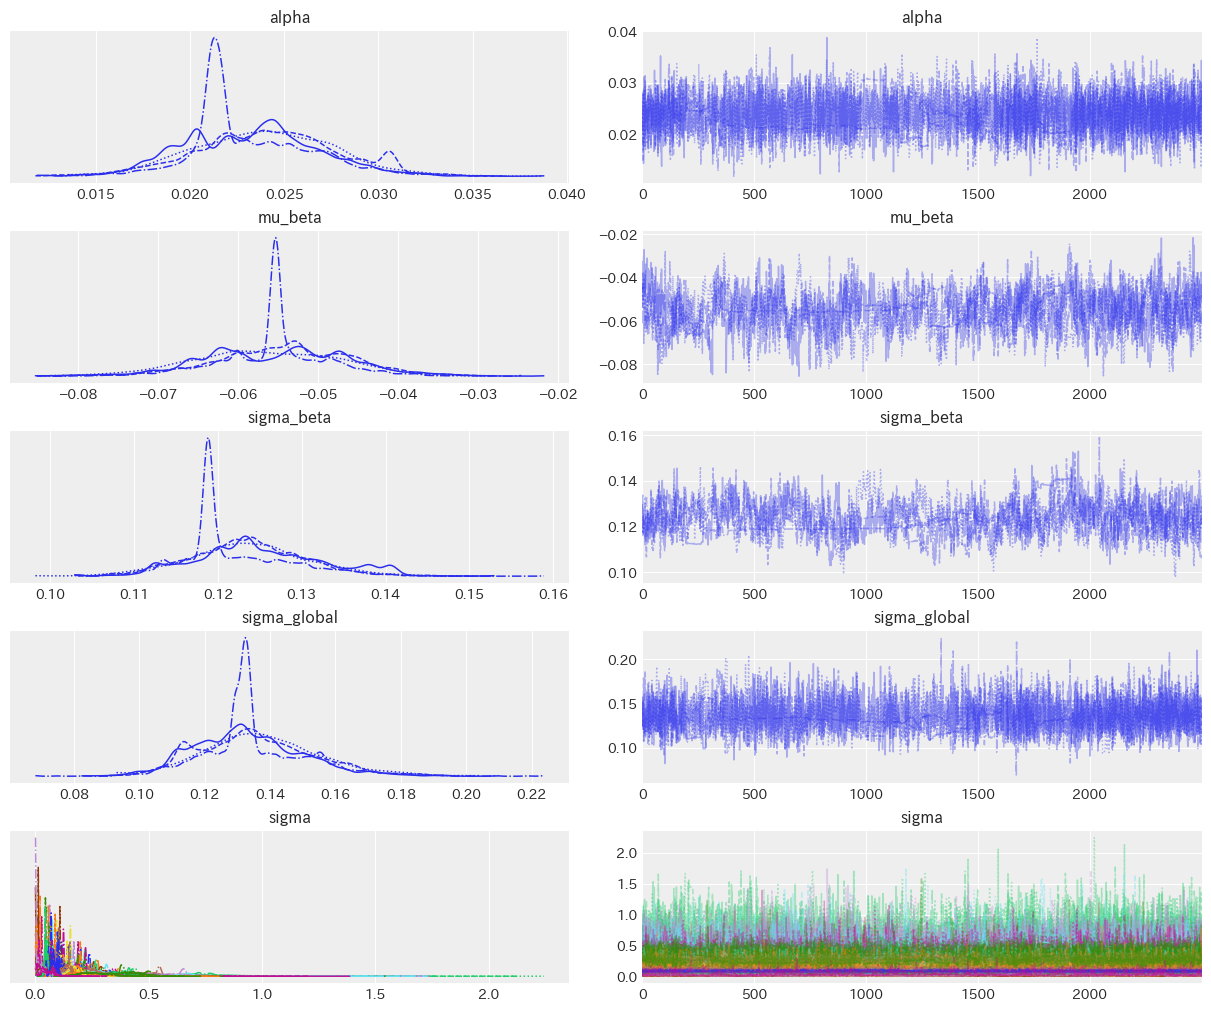

In [8]:
az.plot_trace(trace_h_hetero, var_names=['alpha', 'mu_beta', 'sigma_beta', 'sigma_global', 'sigma']);

## 階層ベイズモデル 均一分散

In [5]:
bridge_year_list = df['bridge_year'].unique()
bridge_year_list.sort()
bridge_year_list

array(['0', '1970', '1972', '1973', '1975', '1976', '1979', '1982',
       '1983', '1987', '1988', '1989', '1991', '1992', '1995', '1996',
       '1997', '1998', '1999', '2000', '2004', '2008', '2011', '2015',
       '2016'], dtype=object)

In [7]:
fully_saturated = dmatrix('C(bridge_year):C(time_since_treatment) - 1', df, return_type='dataframe')
fully_saturated = fully_saturated.loc[:, (fully_saturated != 0).any(axis=0)]
fully_saturated.drop(
    columns=[
        'C(bridge_year)[0]:C(time_since_treatment)[1000.0]',
        'C(bridge_year)[2016]:C(time_since_treatment)[-46.0]',
        'C(bridge_year)[2015]:C(time_since_treatment)[-45.0]',
        'C(bridge_year)[2011]:C(time_since_treatment)[-41.0]',
        'C(bridge_year)[2004]:C(time_since_treatment)[-34.0]',
        'C(bridge_year)[2008]:C(time_since_treatment)[-33.0]',
        'C(bridge_year)[2000]:C(time_since_treatment)[-30.0]',
        'C(bridge_year)[1999]:C(time_since_treatment)[-29.0]',
        'C(bridge_year)[1996]:C(time_since_treatment)[-26.0]',
        'C(bridge_year)[1995]:C(time_since_treatment)[-25.0]',
        'C(bridge_year)[1992]:C(time_since_treatment)[-22.0]',
        'C(bridge_year)[1991]:C(time_since_treatment)[-21.0]',
        'C(bridge_year)[1989]:C(time_since_treatment)[-19.0]',
        'C(bridge_year)[1988]:C(time_since_treatment)[-18.0]',
        'C(bridge_year)[1987]:C(time_since_treatment)[-17.0]',
        'C(bridge_year)[1983]:C(time_since_treatment)[-13.0]',
        'C(bridge_year)[1982]:C(time_since_treatment)[-22.0]',
        'C(bridge_year)[1979]:C(time_since_treatment)[41.0]',
        'C(bridge_year)[1975]:C(time_since_treatment)[45.0]',
        'C(bridge_year)[1973]:C(time_since_treatment)[47.0]',
        'C(bridge_year)[1972]:C(time_since_treatment)[48.0]',
        'C(bridge_year)[1970]:C(time_since_treatment)[50.0]',
    ],
    axis=1, inplace=True
)
fully_saturated

,C(bridge_year)[2016]:C(time_since_treatment)[-41.0],C(bridge_year)[2015]:C(time_since_treatment)[-40.0],C(bridge_year)[2011]:C(time_since_treatment)[-36.0],C(bridge_year)[2016]:C(time_since_treatment)[-36.0],C(bridge_year)[2015]:C(time_since_treatment)[-35.0],C(bridge_year)[2011]:C(time_since_treatment)[-31.0],C(bridge_year)[2016]:C(time_since_treatment)[-31.0],C(bridge_year)[2015]:C(time_since_treatment)[-30.0],C(bridge_year)[2004]:C(time_since_treatment)[-29.0],C(bridge_year)[2008]:C(time_since_treatment)[-28.0],...,C(bridge_year)[1983]:C(time_since_treatment)[37.0],C(bridge_year)[1972]:C(time_since_treatment)[38.0],C(bridge_year)[1982]:C(time_since_treatment)[38.0],C(bridge_year)[1976]:C(time_since_treatment)[39.0],C(bridge_year)[1970]:C(time_since_treatment)[40.0],C(bridge_year)[1975]:C(time_since_treatment)[40.0],C(bridge_year)[1973]:C(time_since_treatment)[42.0],C(bridge_year)[1972]:C(time_since_treatment)[43.0],C(bridge_year)[1976]:C(time_since_treatment)[44.0],C(bridge_year)[1970]:C(time_since_treatment)[45.0]
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
789,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
790,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
791,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
792,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


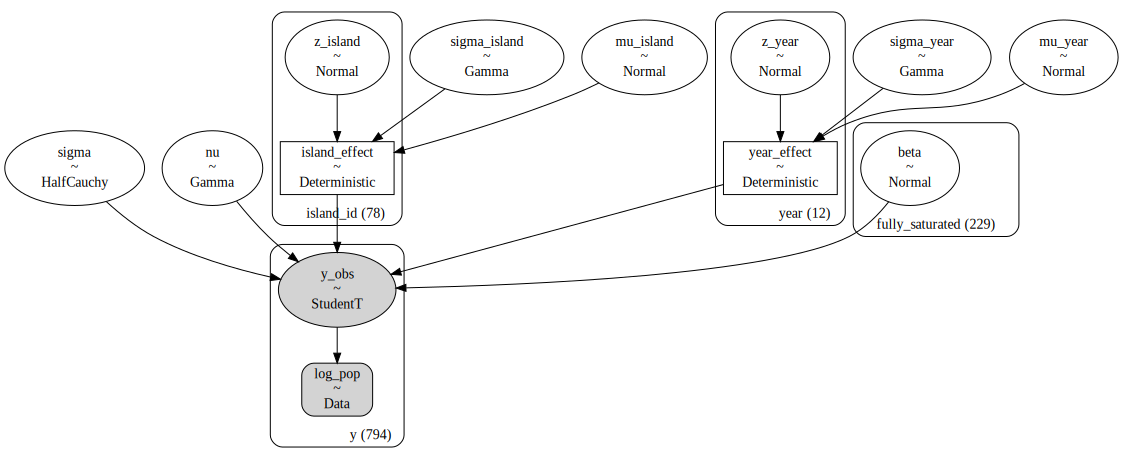

In [8]:
# 年をダミー化
year_dummies = dmatrix('C(year)-1', df, return_type='dataframe')
year_dummies.drop('C(year)[1960]', axis=1, inplace=True)
# 介入経過年数をダミー化
time_since_treatment_dummies = dmatrix('C(time_since_treatment) - 1', df, return_type='dataframe')
time_since_treatment_dummies.drop(columns=['C(time_since_treatment)[-46.0]', 'C(time_since_treatment)[1000.0]'], axis=1, inplace=True)
COORDS = {
    'y': df.index,
    'X': df.index,
    'island_id': mn_island_ids,
    'year': year_dummies.columns,
    'fully_saturated': fully_saturated.columns,
}

with pm.Model(coords=COORDS) as model_homo:
    # data
    log_pop = pm.Data('log_pop', df['log_pop'], dims='y')
    # treatment_group = pm.Data('treatment_group', df['treatment_group'], dims='X')
    # after_treatment = pm.Data('after_treatment', df['after_treatment'], dims='X')

    # priors
    # random effect
    mu_island = pm.Normal('mu_island', mu=5, sigma=1)
    sigma_island = pm.Gamma('sigma_island', alpha=3, beta=1)
    z_island = pm.Normal('z_island', mu=0, sigma=1, dims='island_id')
    island_effect = pm.Deterministic('island_effect', mu_island + sigma_island * z_island, dims='island_id')

    mu_year = pm.Normal('mu_year', mu=-0.1, sigma=1)
    sigma_year = pm.Gamma('sigma_year', alpha=2, beta=1)
    z_year = pm.Normal('z_year', mu=0, sigma=1, dims='year')
    year_effect = pm.Deterministic('year_effect', mu_year + sigma_year * z_year, dims='year')

    # fixed effect
    beta = pm.Normal('beta', mu=0, sigma=1, dims='fully_saturated')
    sigma = pm.HalfCauchy('sigma', beta=1)
    nu = pm.Gamma('nu', alpha=2, beta=0.1)

    # expectation
    mu = pm.math.dot(fully_saturated, beta) + island_effect[island_id] + pm.math.dot(year_dummies, year_effect)

    # likelihood
    y_obs = pm.StudentT('y_obs', nu=nu, mu=mu, sigma=sigma, observed=log_pop, dims='y')

pm.model_to_graphviz(model_homo)

In [11]:
with model_homo:
    trace_homo = pm.sample(
        draws=2000,
        tune=2000,
        chains=4,
        cores=4,
        nuts_sampler='numpyro',
        random_seed=rng,
    )

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [14]:
az.to_netcdf(trace_homo, './mcmc_sample/fully_saturated/homo_kokucho_modified_20250110.nc')

'./mcmc_sample/fully_saturated/homo_kokucho_modified_20250110.nc'

In [15]:
az.summary(trace_homo, var_names=['sigma', 'nu', 'mu_island', 'sigma_island', 'mu_year', 'sigma_year'], hdi_prob=.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.137,0.011,0.115,0.160,0.000,0.000,2266.0,3741.0,1.0
nu,2.405,0.365,1.720,3.105,0.006,0.005,3515.0,4333.0,1.0
mu_island,6.037,0.358,5.328,6.735,0.009,0.006,1571.0,3240.0,1.0
sigma_island,1.980,0.159,1.681,2.291,0.004,0.003,1440.0,2422.0,1.0
mu_year,-0.314,0.337,-0.982,0.347,0.006,0.004,3192.0,3692.0,1.0
sigma_year,0.612,0.157,0.351,0.911,0.003,0.002,3123.0,4178.0,1.0


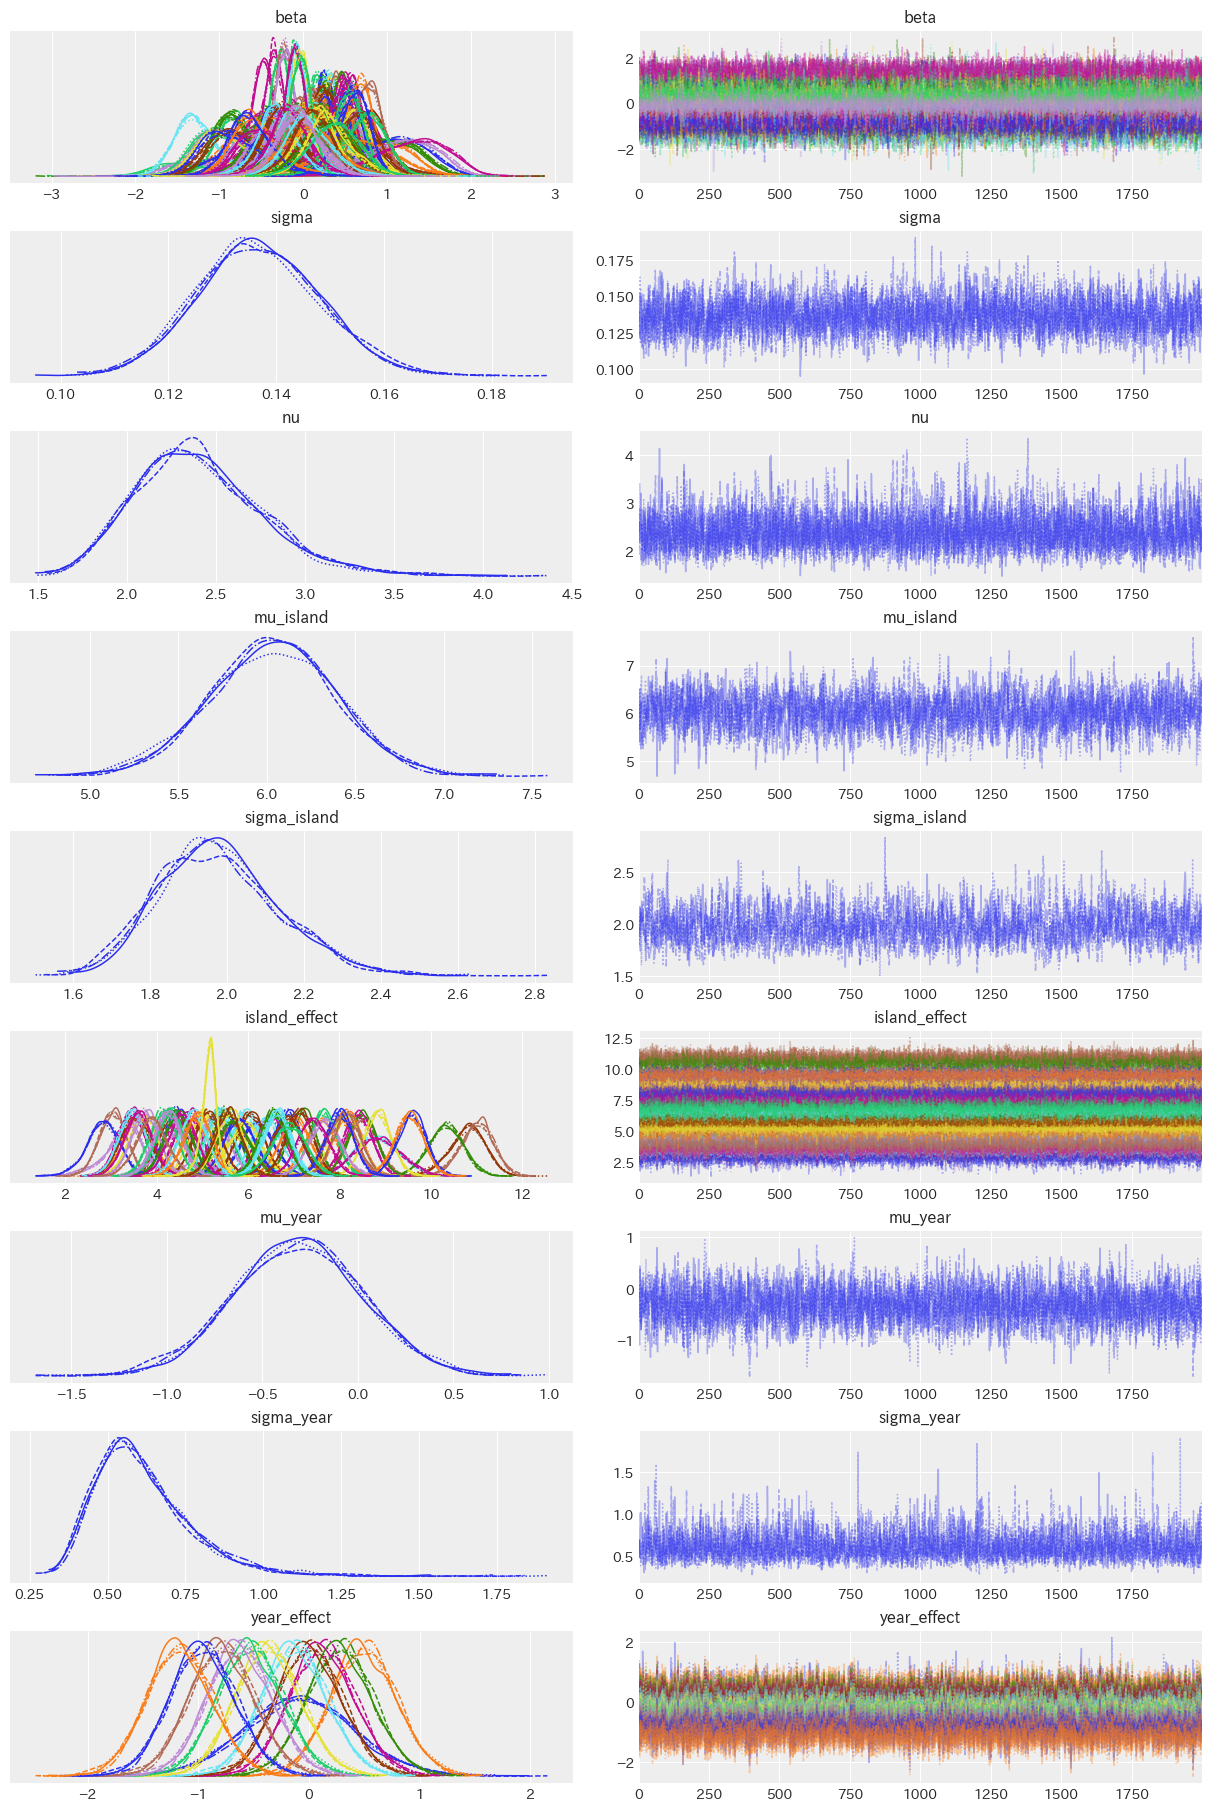

In [16]:
az.plot_trace(trace_homo, var_names=['beta', 'sigma', 'nu', 'mu_island', 'sigma_island', 'island_effect', 'mu_year', 'sigma_year', 'year_effect']);

In [31]:
with model_homo:
    pm.compute_log_likelihood(trace_homo)

Output()

In [32]:
az.waic(trace_homo)

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 8000 posterior samples and 782 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -164.36    30.48
p_waic      375.17        -

There has been a warning during the calculation. Please check the results.

## プロット

In [32]:
beta_df = az.summary(trace_homo, var_names=['beta'], hdi_prob=0.95)
# 正規表現でbridge_yearとtime_since_treatmentを抽出
pattern = r'C\(bridge_year\)\[(\d+)\]:C\(time_since_treatment\)\[(-?\d+)\.0\]'
extracted = beta_df.index.str.extract(pattern)
extracted.index = beta_df.index
beta_df['bridge_year'] = extracted[0].astype(int)
beta_df['time_since_treatment'] = extracted[1].astype(int)
beta_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 229 entries, beta[C(bridge_year)[2016]:C(time_since_treatment)[-41.0]] to beta[C(bridge_year)[1970]:C(time_since_treatment)[45.0]]
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   mean                  229 non-null    float64
 1   sd                    229 non-null    float64
 2   hdi_2.5%              229 non-null    float64
 3   hdi_97.5%             229 non-null    float64
 4   mcse_mean             229 non-null    float64
 5   mcse_sd               229 non-null    float64
 6   ess_bulk              229 non-null    float64
 7   ess_tail              229 non-null    float64
 8   r_hat                 229 non-null    float64
 9   bridge_year           229 non-null    int64  
 10  time_since_treatment  229 non-null    int64  
dtypes: float64(9), int64(2)
memory usage: 21.5+ KB


In [36]:
beta_df = beta_df.sort_values(['bridge_year', 'time_since_treatment'])

In [37]:
beta_df.to_csv('../../data/processed/fully_saturated/homo.csv')

In [4]:
year_effects = az.summary(trace_homo, var_names=['year_effect'], hdi_prob=.95)

In [7]:
pattern = r'year_effect\[C\(year\)\[(\d+)\]\]'
extracted = year_effects.index.str.extract(pattern)
extracted.index = year_effects.index
year_effects['year'] = extracted[0].astype(int)


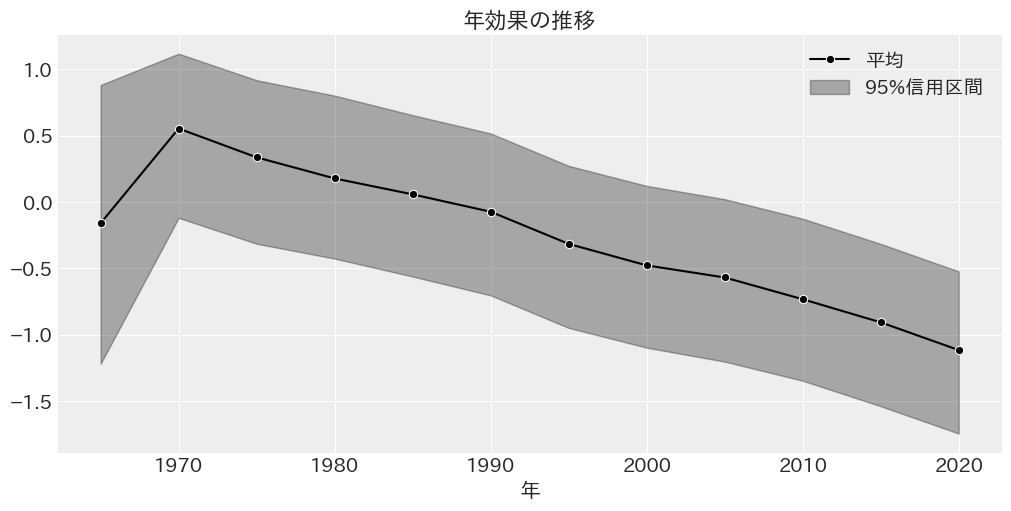

In [16]:
fig, ax = plt.subplots(figsize=figsize)
sns.lineplot(x='year', y='mean', data=year_effects, ax=ax, marker='o', color='black', label='平均')
ax.fill_between(
    x='year',
    y1='hdi_2.5%',
    y2='hdi_97.5%',
    data=year_effects,
    color='black',
    alpha=0.3,
    label='95%信用区間'
)
ax.set_title('年効果の推移')
ax.set_xlabel('年')
ax.set_ylabel('')
ax.legend()

## サンプリングの保存

In [ ]:
az.to_netcdf(trace_h_hetero, './mcmc_sample/fully_saturated/trace_h_hetero.nc')
# az.to_netcdf(trace_h_homo, './mcmc_sample/fully_saturated/trace_h_homo.nc')

In [ ]:
trace_h_hetero = az.from_netcdf('./mcmc_sample/fully_saturated/hie_hetero.nc')